# scTools

> Single-cell large-scale analysis tools

In [ ]:
#| default_exp tools

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

# import

In [ ]:
#| export
import numpy as np
import scanpy as sc
import math
import matplotlib.pyplot as plt

Global seed set to 0


## Functions

In [ ]:
#| export

def plot_violins(ad, genes, groupby='leiden', figsize=(20, 4)):
    """
    Plots violin plots for a list of genes in a specified cluster.

    Parameters:
    ad (AnnData): AnnData object containing the scRNA-seq data.
    genes (list): List of genes to plot.
    groupby (str): Metadata column to group the cells by (default is 'leiden').
    figsize (tuple): Size of the figure (default is (20, 4)).

    Returns:
    None
    """
    # Calculate the number of rows and columns for the subplots
    n_rows = math.ceil(len(genes) / 5)
    n_cols = 5 if len(genes) >= 5 else len(genes)

    # Create the figure and axes for the subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    
    # Iterate over the genes and plot the violin plots
    for i, gene in enumerate(genes):
        # Calculate the row and column indices for the current subplot
        row = i // n_cols
        col = i % n_cols

        # Plot the violin plot for the current gene
        sc.pl.violin(ad, gene, groupby, ax=axs[row, col], show=False, rotation=90)
        
        # Set the title for the current subplot
        axs[row, col].set_title(gene)

        # Add x-axis label to the bottom row of subplots
        if row == n_rows - 1:
            axs[row, col].set_xlabel(groupby)

        # Add y-axis label to the leftmost column of subplots
        if col == 0:
            axs[row, col].set_ylabel('Gene expression')

    # Adjust the spacing between subplots and display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
#| export
def cluster_small_multiples(adata, clust_key, size=60, frameon=False, legend_loc=None, **kwargs):
    """
    Creates small multiples of UMAP plots for each cluster in a specified column of the AnnData object.

    Parameters:
    adata (AnnData): AnnData object containing the scRNA-seq data.
    clust_key (str): Metadata column to group the cells by.
    size (int): Marker size for the scatter plot (default is 60).
    frameon (bool): Whether to display the frame of the plot (default is False).
    legend_loc (str): Location of the legend in the plot (default is None).
    **kwargs: Additional keyword arguments to pass to the `sc.pl.umap()` function.

    Returns:
    None
    """
    # Create a copy of the AnnData object
    tmp = adata.copy()

    # Iterate over the clusters and create a new category column for each cluster
    for i, clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype("category")
        
        # Set the cluster colors for the plot
        try:
            tmp.uns[clust + "_colors"] = ["#d3d3d3", adata.uns[clust_key + "_colors"][i]]
        except:
            pass

    # Plot small multiples of UMAP plots for each cluster
    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values, # exclude the first category (i.e. unassigned)
        color= adata.obs[clust_key].cat.categories.tolist(), # include all categories
        size=size,
        frameon=frameon,
        legend_loc=legend_loc,
        **kwargs,
    )

In [ ]:
#| export
def plot_subgroups(ad,groupby,color='louvain', embedding_basis="X_umap_m5_p50", ncols=5, figsize=4, size=10, legend_loc='on data', frameon=False):
    """
    Plot subgroups of cells based on a categorical observation column using a specified embedding.
    
    Parameters:
        - ad (anndata.AnnData): Annotated Data object.
        - obs_column (str): Name of the categorical observation column to plot subgroups based on.
        - embedding_basis (str, optional): Name of the embedding basis to use. Defaults to "X_umap_m5_p50".
        - color_column (str, optional): Name of the categorical observation column to use for coloring cells. Defaults to "louvain".
        - figsize (tuple, optional): Size of the figure. Defaults to (4*len(groups)//2, 8).
        - size (int, optional): Size of the plotted points. Defaults to 10.
        - legend_loc (str, optional): Location of the legend. Defaults to 'on data'.
        - frameon (bool, optional): Whether to show the frame around the plot. Defaults to False.
    """
    groups = ad.obs[groupby].cat.categories
    
    # Calculate the number of rows and columns needed
    num_groups = len(groups)
    #num_cols = (num_groups + ncols - 1) // ncols
    nrows = (num_groups + ncols - 1) // ncols
    
    # Create a figure with subplots for each group
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize*ncols, figsize*nrows))
    
    # Loop over the groups and plot each in a separate subplot
    if ncols==1:
        for i, group in enumerate(groups):
            row = i
            sc.pl.embedding(ad[ad.obs[groupby] == group], basis=embedding_basis, color=color, ax=axs[row], show=False, size=size, legend_loc=legend_loc, frameon=frameon)
            axs[row].set_title(f"{group}")
    else:
        for i, group in enumerate(groups):
            row = i // ncols
            col = i % ncols #+ (i // ncols) * ncols
            print(row,col)
            sc.pl.embedding(ad[ad.obs[groupby] == group], basis=embedding_basis, color=color, ax=axs[row, col], show=False, size=size, legend_loc=legend_loc, frameon=frameon)
            axs[row, col].set_title(f"{group}")

    #plt.subplots_adjust(wspace=0.4, hspace=0.4)
    # Show the plot
    plt.show()

In [ ]:
#| export
def msample(x, n, frac):
    """
    sample the matrix by number or by fraction.
    if the fraction is larger than the sample number, use number for sampling. Otherwise, use fraction.
    Input
    -----
    x: the matrix to be split
    n: number of vectors to be sampled
    frac: fraction of the total matrix to be sampled
    return
    -----
    sampled selection.
    """
    if len(x) <= np.floor(n / frac):
        if len(x) < 10: frac = 0.9
        return x.sample(frac=frac)
    else:
        return x.sample(n=n)

## Other

In [1]:
#| hide
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

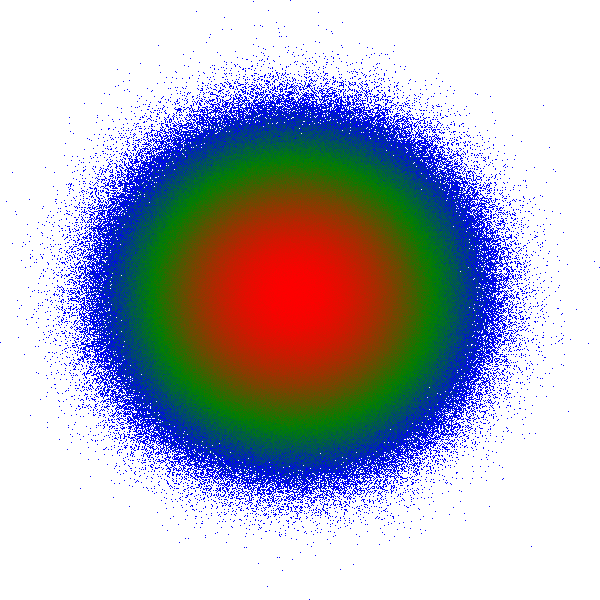

In [ ]:
#| hide
# generate some random data with millions of points
x = np.random.normal(size=12000000)
y = np.random.normal(size=12000000)

# create a datashader canvas
cvs = ds.Canvas(plot_width=600, plot_height=600)

# create a datashader aggregate of the data
agg = cvs.points(pd.DataFrame({'x': x, 'y': y}), 'x', 'y')

# render the aggregate with datashader transfer functions
img = tf.shade(agg, cmap=['blue', 'green', 'red'], how='eq_hist')

# display the image
tf.set_background(img, 'black')
tf.Image(img)

In [ ]:
color_key=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62', '#8da0cb', '#a6d854', '#ffd92f', '#e5c494', '#ffffb3', '#fb8072', '#fdb462', '#fccde5', '#d9d9d9']

In [ ]:
color_key

22